<center><image src="dll_logo.jpeg">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>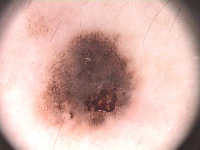</td><td>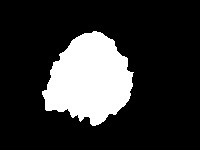</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [760]:
# !gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [761]:
# !unrar x PH2Dataset.rar

In [5]:
!export PYTORCH_ENABLE_MPS_FALLBACK=1

In [6]:
import os

os.environ["PYTPYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [7]:
import torch
import torch.nn.functional as F
import torch.nn as nn

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [8]:
from skimage.io import imread
import os

root = "PH2Dataset"

images = []
lesions = []
for root, dirs, files in os.walk(os.path.join(root, "PH2 Dataset images")):
    if root.endswith("_Dermoscopic_Image"):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith("_lesion"):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [9]:
from skimage.transform import resize

size = (256, 256)
X = [
    resize(
        x,
        size,
        mode="constant",
        anti_aliasing=True,
    )
    for x in images
]
Y = [
    resize(
        y,
        size,
        mode="constant",
        anti_aliasing=False,
    )
    > 0.5
    for y in lesions
]

In [10]:
import numpy as np

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f"Loaded {len(X)} images")

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

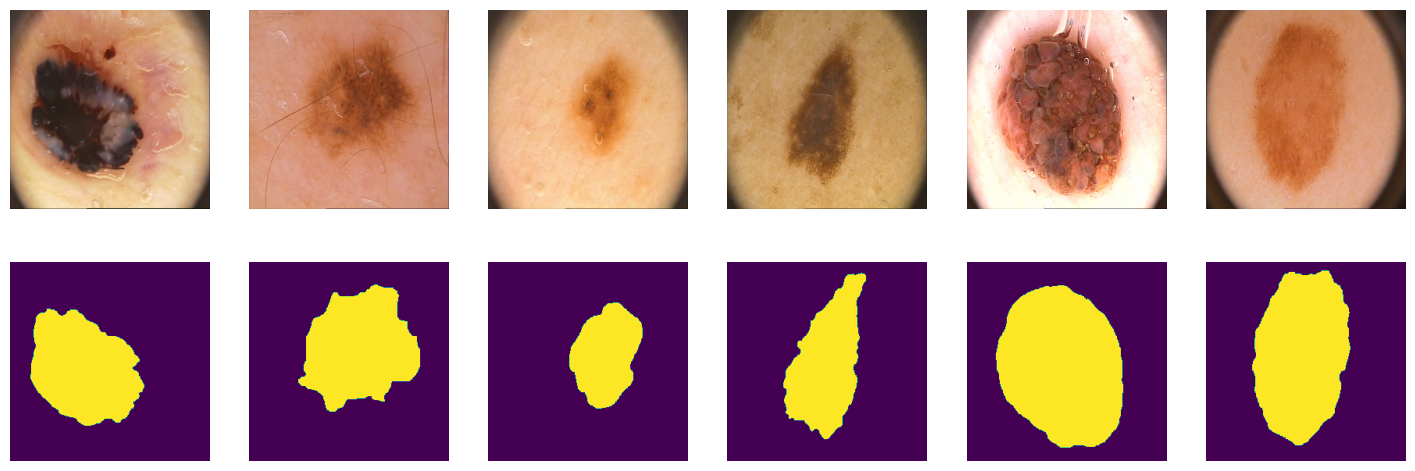

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i + 7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [12]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [13]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [14]:
from torch.utils.data import DataLoader

batch_size = 25
train_dataloader = DataLoader(
    list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
    batch_size=batch_size,
    shuffle=True,
)
valid_dataloader = DataLoader(
    list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = DataLoader(
    list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
    batch_size=batch_size,
    shuffle=True,
)

In [15]:
# DEVICE = torch.device("mps" if torch.mps.is_available() else "cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:



<p style="align: center;"><img align=center src="segmask.png" width=1000 height=800/></p>

In [773]:
# !pip install torchmetrics
# !conda install torchmetrics -y

In [774]:
# !conda list | grep metrics

In [79]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average="micro").to(DEVICE)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

- Начнем с исходной формулы $[1]$: $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right]$$
- Сначала сосредоточимся на одном элементе (убирая суммирование и индекс $i$ для ясности): $$\mathcal L_{BCE}(y, \hat y) = -\left[y\log\sigma(\hat y) + (1-y)\log(1-\sigma(\hat y))\right]$$
$~$
- $\sigma(x) = \frac{1}{1+e^{-x}} \implies 1-\sigma(x) = \frac{e^{-x}}{1+e^{-x}}.$
Подставим эти выражения в уравнение: $$\mathcal L_{BCE} = -\left[y\log\left(\frac{1}{1+e^{-\hat y}}\right) + (1-y)\log\left(\frac{e^{-\hat y}}{1+e^{-\hat y}}\right)\right]$$
$~$
- Используем свойства логарифма $\log(a/b) = \log(a) - \log(b)$, $\log(1) = 0$ и $\log(e^{-\hat y}) = -\hat y$: $$\mathcal L_{BCE} = -\left[y(-\log(1+e^{-\hat y})) + (1-y)(-\hat y - \log(1+e^{-\hat y}))\right]$$
- Распределим отрицательный знак: $$\mathcal L_{BCE} = y\log(1+e^{-\hat y}) - (1-y)(-\hat y - \log(1+e^{-\hat y}))$$
- Раскроем скобки во втором слагаемом: $$\mathcal L_{BCE} = y\log(1+e^{-\hat y}) + (1-y)\hat y + (1-y)\log(1+e^{-\hat y})$$
$~$
- Объединим подобные члены в первом и третьем слагаемых и раскроем скобки во втором, получив искомое: $$\mathcal L_{BCE} = \hat y - y\hat y + \log(1+e^{-\hat y})$$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [17]:
bce_torch = nn.BCELoss(reduction="sum")  # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction="sum")

In [18]:
def bce_true(y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
    return -(
        y_real * torch.log(torch.sigmoid(y_pred))
        + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred))
    ).sum(axis=None)


def bce_loss(y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).sum(axis=None)

Проверим корректность работы на простом примере

In [19]:
# fmt: off
y_pred = torch.randn(3, 2, requires_grad=False)
y_real = torch.rand(3, 2, requires_grad=False)

print(f"BCE loss from scratch bce_loss = {bce_loss(y_pred, y_real)}")
print(f"BCE loss честно посчитанный = {bce_true(y_pred, y_real)}")
print(f"BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_real)}")
print(f"BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_real)}")

BCE loss from scratch bce_loss = 4.976214408874512
BCE loss честно посчитанный = 4.976214408874512
BCE loss from torch bce_torch = 4.976214408874512
BCE loss from torch with logits bce_torch = 4.976214408874512


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [20]:
assert np.isclose(bce_loss(y_pred, y_real), bce_torch(torch.sigmoid(y_pred), y_real))
assert np.isclose(bce_loss(y_pred, y_real), bce_torch_with_logits(y_pred, y_real))
assert np.isclose(bce_true(y_pred, y_real), bce_torch(torch.sigmoid(y_pred), y_real))
assert np.isclose(bce_true(y_pred, y_real), bce_torch_with_logits(y_pred, y_real))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [22]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_real = torch.randint(0, 2, (2, 1, 3, 3))

print(f"BCE loss from scratch bce_loss = {bce_loss(y_pred, y_real)}")
print(f"BCE loss честно посчитанный = {bce_true(y_pred, y_real)}")
print(
    f"BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_real.to(torch.float))}"
)
print(
    f"BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_real.to(torch.float))}"
)

BCE loss from scratch bce_loss = 12.064459800720215
BCE loss честно посчитанный = 12.064459800720215
BCE loss from torch bce_torch = 12.064459800720215
BCE loss from torch with logits bce_torch = 12.064459800720215


In [23]:
assert np.isclose(
    bce_loss(y_pred, y_real), bce_torch(torch.sigmoid(y_pred), y_real.to(torch.float))
)
assert np.isclose(
    bce_loss(y_pred, y_real), bce_torch_with_logits(y_pred, y_real.to(torch.float))
)
assert np.isclose(
    bce_true(y_pred, y_real), bce_torch(torch.sigmoid(y_pred), y_real.to(torch.float))
)
assert np.isclose(
    bce_true(y_pred, y_real), bce_torch_with_logits(y_pred, y_real.to(torch.float))
)

Давайте посчитаем на реальных логитах и сегментационной маске:

In [782]:
# !gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

In [24]:
path_to_dummy_samples = "for_asserts"
dummpy_sample = {
    "logits": torch.load(f"{path_to_dummy_samples}/logits.pt"),
    "labels": torch.load(f"{path_to_dummy_samples}/labels.pt"),
}
dummpy_sample["labels"] = dummpy_sample["labels"].to(DEVICE)
dummpy_sample["logits"] = dummpy_sample["logits"].to(DEVICE)

/var/folders/ck/c65tgxxs72q4jb2lj3m952j40000gn/T/ipykernel_87103/4184975818.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  "logits": torch.load(f"{path_to_dummy_samples

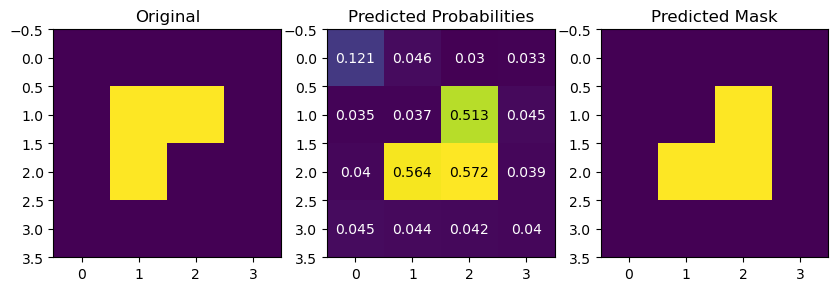

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3 * 10))

ax1.imshow(dummpy_sample["labels"].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample["logits"].sigmoid().squeeze(1)[0].cpu())
for (j, i), label in np.ndenumerate(
    dummpy_sample["logits"].sigmoid().squeeze(1)[0].cpu()
):
    if label < 0.5:
        color = "white"
    else:
        color = "black"
    ax2.text(i, j, round(label, 3), color=color, ha="center", va="center")

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample["logits"].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [26]:
bce_loss_score = bce_loss(dummpy_sample["logits"].cpu(), dummpy_sample["labels"].cpu())
bce_true_score = bce_true(dummpy_sample["logits"].cpu(), dummpy_sample["labels"].cpu())
bce_torch_score = bce_torch(
    torch.sigmoid(dummpy_sample["logits"].cpu()), dummpy_sample["labels"].cpu().float()
)
bce_torch_with_logits_score = bce_torch_with_logits(
    dummpy_sample["logits"].cpu(), dummpy_sample["labels"].cpu().float()
)
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

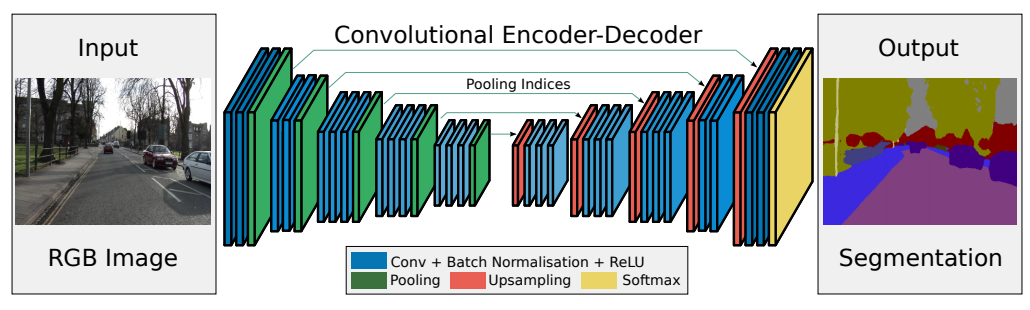

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [27]:
import torch.optim as optim
from torchvision import models
from time import time

from matplotlib import rcParams

rcParams["figure.figsize"] = (15, 4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [28]:
def make_conv_layer(
    in_channels: int,
    out_channels: int,
    kernel_size: int = 3,
    padding: int = 1,
) -> nn.Sequential:
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [29]:
class EncoderBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        depth: int = 2,
        kernel_size: int = 3,
        padding: int = 1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            conv_layer = make_conv_layer(
                in_channels=in_channels if i == 0 else out_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=padding,
            )
            self.layers.append(conv_layer)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        x, idx = self.pool(x)

        return x, idx

In [30]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        depth: int = 2,
        kernel_size: int = 3,
        padding: int = 1,
        classification: bool = False,
    ) -> None:
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.layers = nn.ModuleList()
        common = kernel_size, padding
        for i in range(depth):
            if i == depth - 1:
                if classification:
                    conv_layer = nn.Conv2d(
                        in_channels,
                        out_channels,
                        kernel_size,
                        padding=1,
                    )
                else:
                    conv_layer = make_conv_layer(in_channels, out_channels, *common)
            else:
                conv_layer = make_conv_layer(in_channels, in_channels, *common)

            self.layers.append(conv_layer)

    def forward(self, x, idx):
        x = self.unpool(x, idx)

        for layer in self.layers:
            x = layer(x)

        return x

In [32]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4, depth=3)
        self.enc3 = EncoderBlock(features * 4, features * 8, depth=3)

        # Bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3)
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3)

        # Decoder
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 2, features)
        self.dec3 = DecoderBlock(
            features, out_channels, classification=True
        )  # No activation

    def forward(self, x):
        # Encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        e2, ind2 = self.enc2(e1)
        e3, ind3 = self.enc3(e2)

        # Bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # Decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)

        # classification layer
        output = self.dec3(d2, ind0)

        return output

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [33]:
from tqdm.notebook import tqdm

In [34]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None) -> float:
    model.train()
    running_loss = 0.0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        processed_data += inputs.size(0)

    if scheduler:
        scheduler.step()

    train_loss = running_loss / processed_data

    return train_loss

In [35]:
def eval_epoch(model, val_loader, criterion) -> float:
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item()
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size

    return val_loss

In [ ]:
def train(
    train_dataloader: DataLoader,
    valid_dataloader: DataLoader,
    model: nn.Module,
    num_epochs: int,
    lr: float = 1.2e-3,
    weight_decay: float = 1e-4,
    criterion: nn.Module = nn.BCEWithLogitsLoss(reduction="sum"),
    initial_epoch: int = 0,
    optimizer=None,
    loss: float | None = None,
) -> list[tuple[float, float]]:
    log_template = """
    Epoch {ep}\
    train_loss: {t_loss:0.4f}, val_loss: {v_loss:0.4f}
    """
    best_loss = loss or float("inf")
    optimizer = optimizer or optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    history = []
    with tqdm(
        desc="epoch",
        total=num_epochs,
        leave=True,
        initial=initial_epoch,
    ) as progress_bar:
        for epoch in range(num_epochs):
            train_loss = fit_epoch(
                model,
                train_dataloader,
                criterion,
                optimizer,
                scheduler,
            )
            val_loss = eval_epoch(model, valid_dataloader, criterion)
            history.append((train_loss, val_loss))

            print("loss", val_loss)

            if val_loss < best_loss:
                best_loss = val_loss

                file_name = f"best_{model.__class__.__name__.lower()}.pt"
                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "val_loss": val_loss,
                        "lr": lr,
                        "scheduler": scheduler.state_dict(),
                    },
                    file_name,
                )
                print(f"New loss minimum found, model saved as {file_name}")

            progress_bar.update(1)
            log = log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss)
            tqdm.write(log)

    return history

Обучите модель **SegNet**. В качестве оптимизатора можно взять Adam.

### SegNet BCE loss

In [38]:
segnet = SegNet().to(DEVICE)
# optimizer = optim.Adam(segnet.parameters(), lr=1.2e-3, weight_decay=1e-4)
# criterion = nn.BCEWithLogitsLoss(reduction="mean")

# checkpoint = torch.load(f"best_{SegNet.__name__.lower()}.pt", weights_only=False)

# segnet.load_state_dict(checkpoint["model_state_dict"])
# optimizer = optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# epoch = checkpoint["epoch"]
# loss = checkpoint["val_loss"]
# lr = checkpoint["lr"]

<All keys matched successfully>

In [ ]:
history = train(
    train_dataloader,
    valid_dataloader,
    model=segnet,
    num_epochs=25,
)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 45273.6625
New loss minimum found, model saved as best_segnet.pt

    Epoch 1    train_loss: 44790.5825, val_loss: 45273.6625
    
loss 44261.5375
New loss minimum found, model saved as best_segnet.pt

    Epoch 2    train_loss: 36912.1806, val_loss: 44261.5375
    
loss 41850.04625
New loss minimum found, model saved as best_segnet.pt

    Epoch 3    train_loss: 27424.1931, val_loss: 41850.0462
    
loss 40391.94625
New loss minimum found, model saved as best_segnet.pt

    Epoch 4    train_loss: 19945.5569, val_loss: 40391.9463
    
loss 41225.35625

    Epoch 5    train_loss: 18556.2375, val_loss: 41225.3562
    
loss 32816.1125
New loss minimum found, model saved as best_segnet.pt

    Epoch 6    train_loss: 16798.1919, val_loss: 32816.1125
    
loss 28769.955
New loss minimum found, model saved as best_segnet.pt

    Epoch 7    train_loss: 15447.2619, val_loss: 28769.9550
    
loss 23479.52125
New loss minimum found, model saved as best_segnet.pt

    Epoch 8    train_loss: 1

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
segnet = SegNet().to(DEVICE)
checkpoint = torch.load(f"best_{SegNet.__name__.lower()}.pt", weights_only=False)
segnet.load_state_dict(checkpoint["model_state_dict"])

In [ ]:
loss, val_loss = zip(*history)

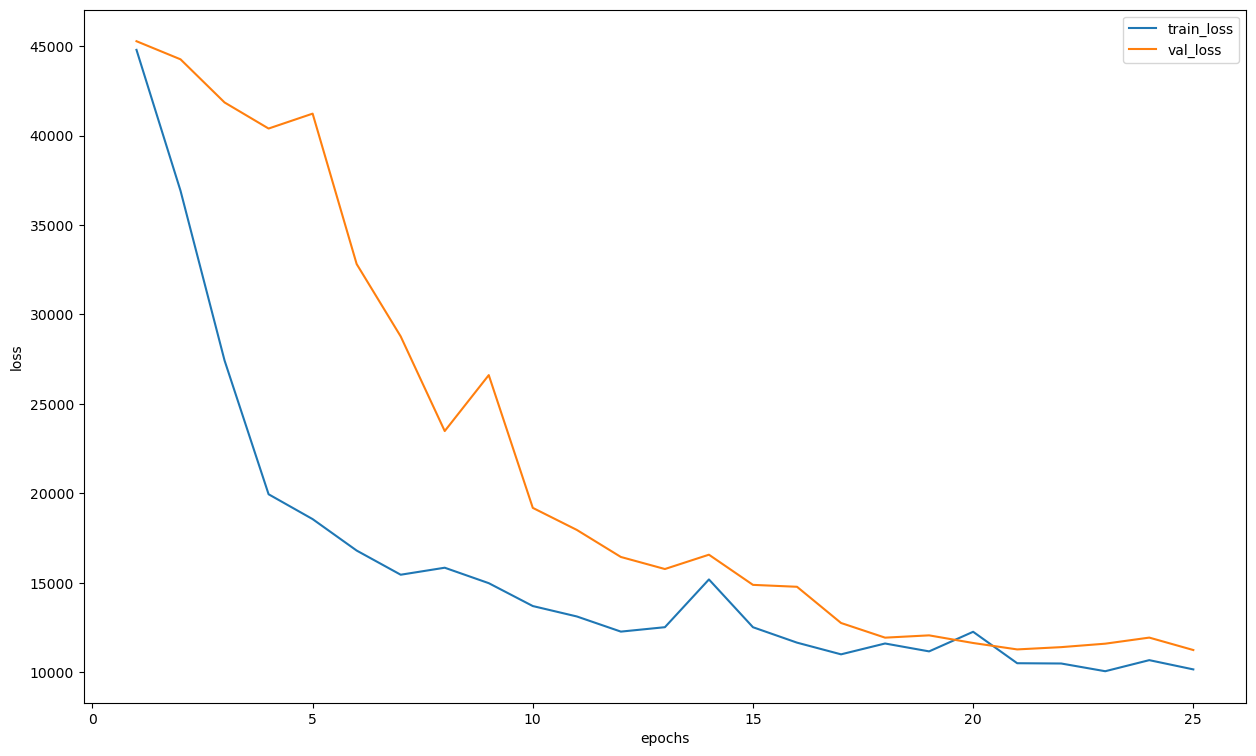

In [852]:
plt.figure(figsize=(15, 9))
plt.plot(range(1, len(loss) + 1), loss, label="train_loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [44]:
X, Y = next(iter(test_dataloader))
segnet.eval()

with torch.no_grad():
    X_pred = segnet(X)

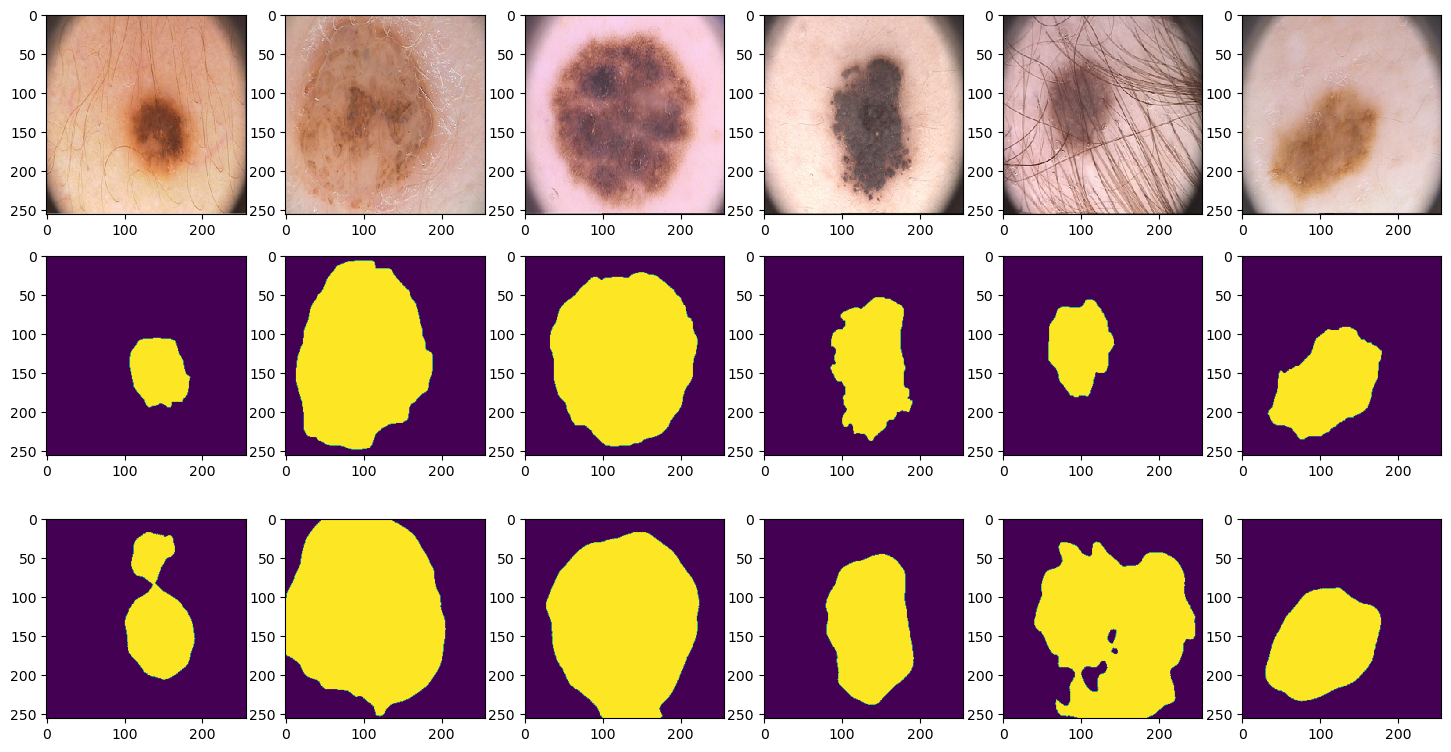

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 24))
for i in range(6):
    axes = plt.subplot(1, 6, i + 1)  # image
    plt.imshow(X[i].numpy().transpose(1, 2, 0), interpolation="nearest")

    plt.subplot(2, 6, i + 7)  # prediction
    plt.imshow(X_pred[i].numpy().transpose(1, 2, 0) > 0.5)

    plt.subplot(4, 6, i + 13)  # ground truth
    plt.imshow(Y[i].squeeze())

plt.show();

In [46]:
eval_epoch(
    segnet,
    test_dataloader,
    criterion=nn.BCEWithLogitsLoss(reduction="mean"),
)

0.02246165633201599

In [49]:
eval_epoch(
    segnet,
    test_dataloader,
    criterion=nn.BCEWithLogitsLoss(reduction="sum"),
)

36801.18

In [50]:
iou_score(X_pred, Y)

tensor(0.8025)

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [641]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    """
    Это именно метрика, не лосс.
    """
    eps = 1e-8
    preds = logits.sigmoid() > threshold
    tp_x2 = 2 * (preds & labels.bool()).sum() + eps
    score = tp_x2 / (preds.sum() + labels.sum() + eps)

    return score

Проверим на корректность функцию dice_score:

In [66]:
from torchmetrics.classification import Dice

dice = Dice(average="micro").to(DEVICE)
dice(dummpy_sample["logits"].sigmoid(), dummpy_sample["labels"].to(int))

tensor(0.6667)

In [649]:
assert dice(
    dummpy_sample["logits"].sigmoid(), dummpy_sample["labels"].to(int)
) == dice_score(dummpy_sample["logits"], dummpy_sample["labels"])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [650]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
    """
    Это лосс.
    """
    eps = 1e-8
    preds = logits.sigmoid()
    tp_x2 = 2 * (preds * labels).sum() + eps
    loss = 1 - tp_x2 / (preds.sum() + labels.sum() + eps)

    return loss

Проверка на корректность:

In [916]:
from segmentation_models_pytorch.losses import DiceLoss

dice_loss_torch = DiceLoss(mode="binary")
dice_loss_torch(dummpy_sample["logits"], dummpy_sample["labels"])

tensor(0.5756)

In [652]:
assert dice_loss_torch(
    dummpy_sample["logits"], dummpy_sample["labels"].to(int)
) == dice_loss(dummpy_sample["logits"], dummpy_sample["labels"])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i [1 - (\sigma[\hat y_i]y_i + (1 - \sigma[\hat y_i]) (1-y_i))]^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [745]:
def focal_loss(y_real, y_pred, eps=2e-7, gamma=2):
    p = y_pred.sigmoid() * y_real + (1 - y_pred.sigmoid()) * (1 - y_real)
    alpha = (1 - p) ** gamma
    bce_loss = y_pred - y_real * y_pred + (1 + (-y_pred).exp()).log()
    focal_loss = (alpha * bce_loss).sum(axis=None) - eps

    return focal_loss

Проверка корректности функции:

In [746]:
from torchvision.ops import sigmoid_focal_loss

sigmoid_focal_loss(
    dummpy_sample["logits"], dummpy_sample["labels"], alpha=-1, gamma=2, reduction="sum"
)

tensor(3.6161)

In [747]:
assert sigmoid_focal_loss(
    dummpy_sample["logits"], dummpy_sample["labels"], alpha=-1, gamma=2, reduction="sum"
) == focal_loss(dummpy_sample["labels"], dummpy_sample["logits"], gamma=2.0)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

### Tversky loss
Реализуем описанную в третьей научной статье функцию потерь, основанную на [индексе Тверского](https://en.wikipedia.org/wiki/Tversky_index). Он является обощением [коэффициента Дайса-Сёренсена](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%A1%D1%91%D1%80%D0%B5%D0%BD%D1%81%D0%B5%D0%BD%D0%B0) и $F_\beta$-меры и определяется как соотношение мощностей множеств с коэффициентами:
$$S(P,G;\alpha,\beta)=\frac{|P\cap G|}{|P\cap G|+\alpha|P\setminus G|+\beta|G\setminus P|} ,$$

где (в нашем случае) $P$ и $G$ – множества положительных предсказаний модели и истинных меток соответственно.\
Индекс принимает значения из $[0, 1]$, – когда ошибок нет (множества совпадают), он равен $1$. Так как нам от функции потерь нужно обратное, преобразуем выражение в более подходящих для наших задач категориях матрицы ошибок:
$$T(\alpha,\beta)=1-\frac{TP}{TP+\alpha FP+\beta FN}$$

Выражение корректно, если модель предсказывает булевы значения принадлежности к множеству, однако SegNet выводит логиты, и мы можем использовать их, прогнав через сигмоиду. Можно было бы дополнительно установить отсечку, чтобы получить булевы тензоры, но большого смысла в этом нет, мы только потеряем информацию.

Такая функция потерь позволит регулировать значимость ошибок первого и второго рода, что важно в задаче определения рака кожи: ложно-отрицательные (не)срабатывания гораздо опаснее ложно-положительных, и мы должны штрафовать за них сильнее. За их вес отвечает коэффициент $\beta$:

In [1081]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha: float = 0.5, beta: float = 0.5):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_pred, y_real):
        y_pred = y_pred.sigmoid()

        tp = (y_real * y_pred).sum()
        fp = ((1 - y_real) * y_pred).sum()
        fn = ((1 - y_pred) * y_real).sum()

        tversky_loss = 1 - tp / (tp + self.alpha * fp + self.beta * fn)

        return tversky_loss

Обучим SegNet c этой функцией потерь, задав $\beta$ равным 0,7:

In [1091]:
segnet_tversky = SegNet().to(DEVICE)
criterion = TverskyLoss(alpha=0.3, beta=0.7)

tversky_history = train(
    train_dataloader,
    valid_dataloader,
    model=segnet_tversky,
    num_epochs=25,
    criterion=criterion,
)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 0.022133374214172365
New loss minimum found, model saved as best_segnet.pt

    Epoch 1    train_loss: 0.0201, val_loss: 0.0221
    
loss 0.013476330041885375
New loss minimum found, model saved as best_segnet.pt

    Epoch 2    train_loss: 0.0143, val_loss: 0.0135
    
loss 0.01377583384513855

    Epoch 3    train_loss: 0.0117, val_loss: 0.0138
    
loss 0.013338745832443237
New loss minimum found, model saved as best_segnet.pt

    Epoch 4    train_loss: 0.0098, val_loss: 0.0133
    
loss 0.013708542585372924

    Epoch 5    train_loss: 0.0092, val_loss: 0.0137
    
loss 0.011414085626602172
New loss minimum found, model saved as best_segnet.pt

    Epoch 6    train_loss: 0.0086, val_loss: 0.0114
    
loss 0.00950143575668335
New loss minimum found, model saved as best_segnet.pt

    Epoch 7    train_loss: 0.0073, val_loss: 0.0095
    
loss 0.008140379190444946
New loss minimum found, model saved as best_segnet.pt

    Epoch 8    train_loss: 0.0068, val_loss: 0.0081
    
loss 0

In [1092]:
loss, val_loss = zip(*tversky_history)

In [ ]:
# checkpoint = torch.load(f"best_{SegNet.__name__.lower()}.pt", weights_only=False)
# segnet.load_state_dict(checkpoint["model_state_dict"])

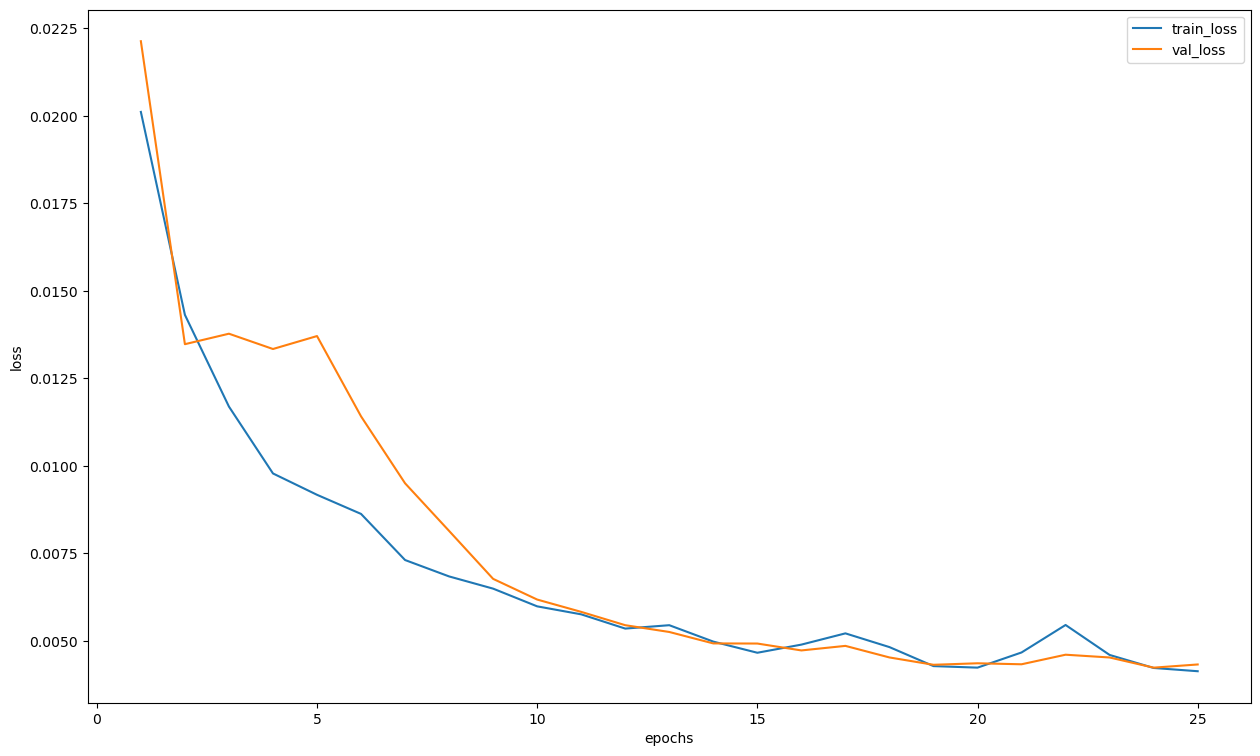

In [1093]:
plt.figure(figsize=(15, 9))
plt.plot(range(1, len(loss) + 1), loss, label="train_loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [1094]:
X, Y = next(iter(test_dataloader))

In [1100]:
with torch.no_grad():
    X_pred = segnet_tversky(X)

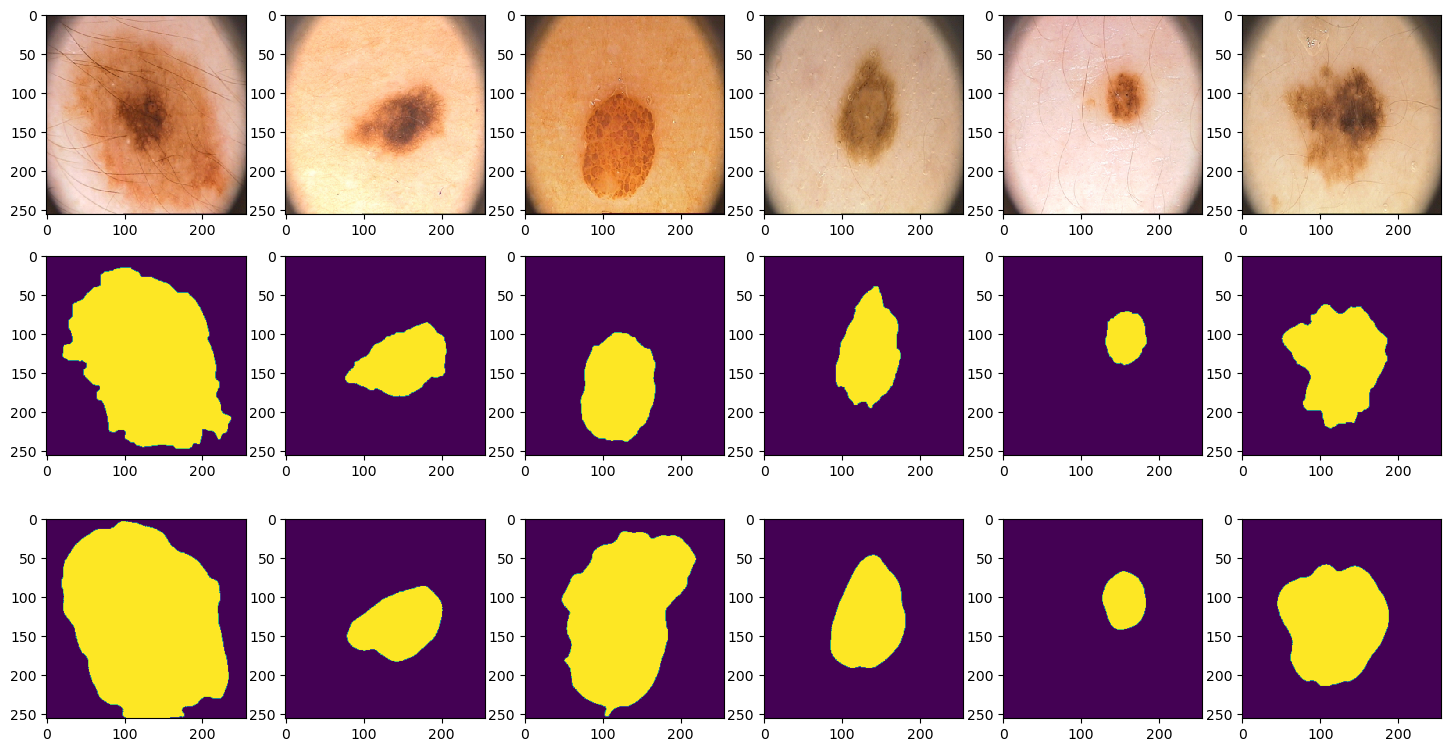

In [1101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 24))
for i in range(6):
    axes = plt.subplot(1, 6, i + 1)  # image
    plt.imshow(X[i].numpy().transpose(1, 2, 0), interpolation="nearest")

    plt.subplot(4, 6, i + 13)  # ground truth
    plt.imshow(Y[i].squeeze())

    plt.subplot(2, 6, i + 7)  # prediction
    plt.imshow(X_pred[i].numpy().transpose(1, 2, 0) > 0.5)

plt.show();

В целом неплохо, можно ещё поиграться с коэффициентами. `Dice score` не лучший, но вполне приемлемый для эксперимента:

In [1109]:
dice_score(X_pred, Y)

tensor(0.7610)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



### Dice Loss

In [931]:
segnet = SegNet().to(DEVICE)

In [ ]:
criterion = DiceLoss(mode="binary")

In [ ]:
dice_history = train(
    train_dataloader,
    valid_dataloader,
    model=segnet,
    num_epochs=25,
    criterion=criterion,
)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 1.9468812561035156
New loss minimum found, model saved as best_segnet.pt

    Epoch 1    train_loss: 0.0204, val_loss: 1.9469
    
loss 3.201671295166016

    Epoch 2    train_loss: 0.0200, val_loss: 3.2017
    
loss 1.8691828918457032
New loss minimum found, model saved as best_segnet.pt

    Epoch 3    train_loss: 0.0183, val_loss: 1.8692
    
loss 0.04447345495223999
New loss minimum found, model saved as best_segnet.pt

    Epoch 4    train_loss: 0.0153, val_loss: 0.0445
    
loss 0.012849352359771728
New loss minimum found, model saved as best_segnet.pt

    Epoch 5    train_loss: 0.0120, val_loss: 0.0128
    
loss 0.012779417037963868
New loss minimum found, model saved as best_segnet.pt

    Epoch 6    train_loss: 0.0102, val_loss: 0.0128
    
loss 0.010531093776226044
New loss minimum found, model saved as best_segnet.pt

    Epoch 7    train_loss: 0.0103, val_loss: 0.0105
    
loss 0.009225490987300872
New loss minimum found, model saved as best_segnet.pt

    Epoch 8    

In [1105]:
loss, val_loss = zip(*dice_history[4:])

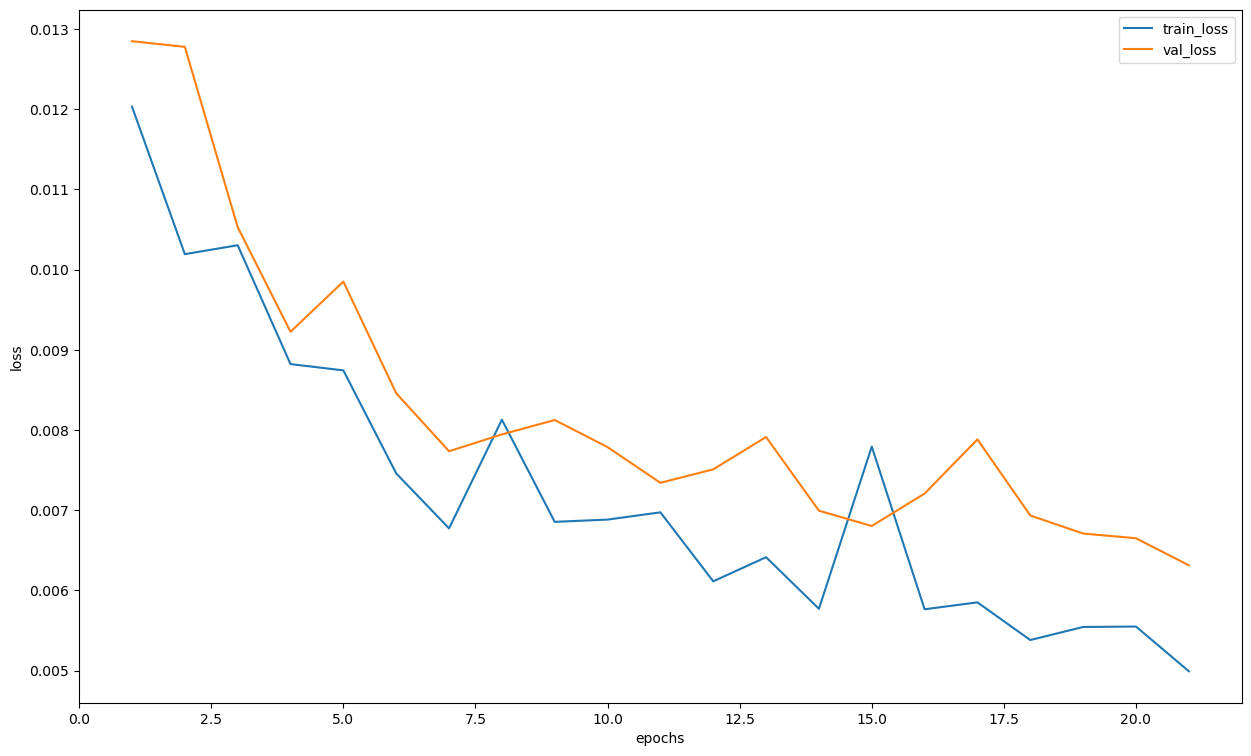

In [1106]:
plt.figure(figsize=(15, 9))
plt.plot(range(1, len(loss) + 1), loss, label="train_loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [928]:
X, Y = next(iter(test_dataloader))

In [929]:
with torch.no_grad():
    X_pred = segnet(X).numpy()

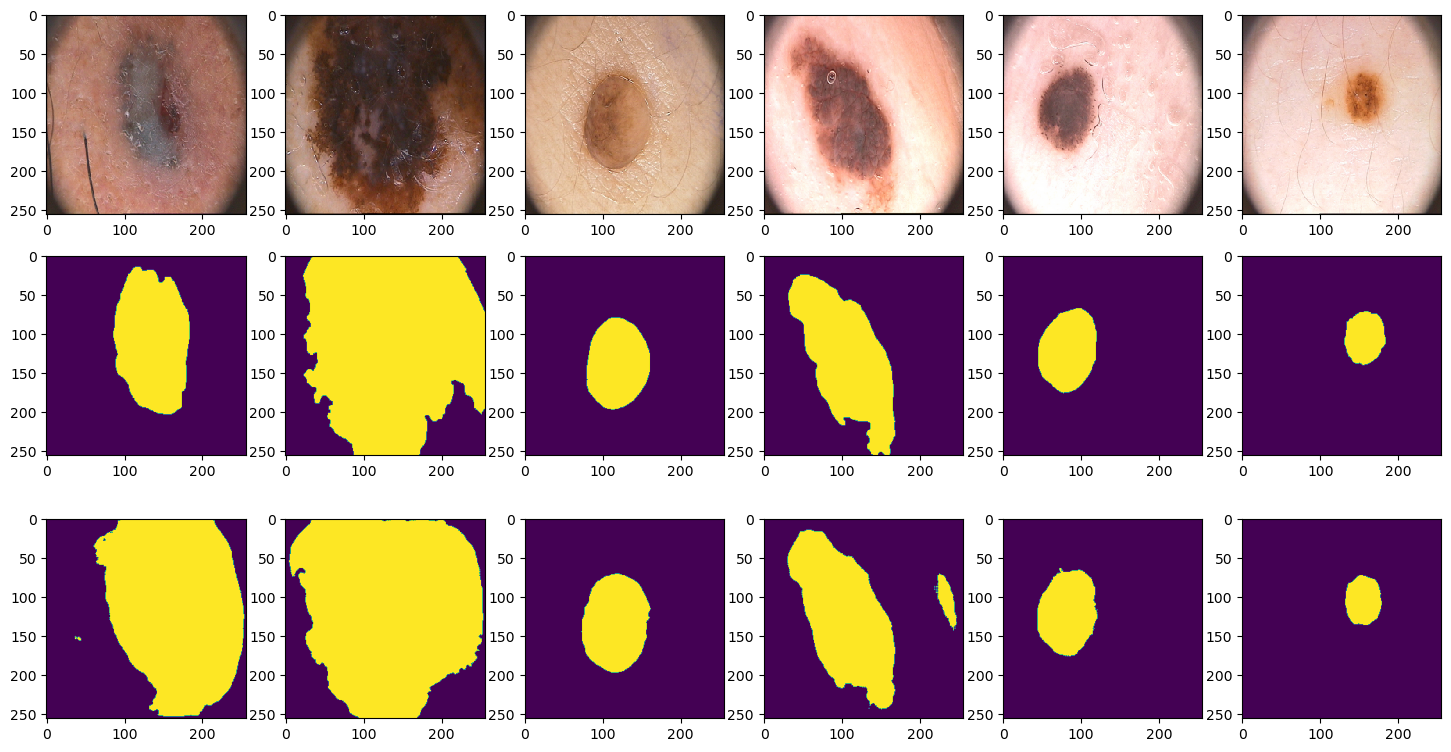

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 24))
for i in range(6):
    axes = plt.subplot(1, 6, i + 1)  # image
    plt.imshow(X[i].numpy().transpose(1, 2, 0), interpolation="nearest")

    plt.subplot(2, 6, i + 7)  # prediction
    plt.imshow(X_pred[i].transpose(1, 2, 0) > 0.5)

    plt.subplot(4, 6, i + 13)  # ground truth
    plt.imshow(Y[i].squeeze())

plt.show();

### Focal loss

In [ ]:
criterion = sigmoid_focal_loss

In [ ]:
focal_history = train(
    train_dataloader,
    valid_dataloader,
    model=segnet,
    num_epochs=25,
    criterion=criterion,
)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 0.6810889053344726
New loss minimum found, model saved as best_segnet.pt

    Epoch 1    train_loss: 0.0283, val_loss: 0.6811
    
loss 0.03197975993156433
New loss minimum found, model saved as best_segnet.pt

    Epoch 2    train_loss: 0.0257, val_loss: 0.0320
    
loss 0.026541986465454102
New loss minimum found, model saved as best_segnet.pt

    Epoch 3    train_loss: 0.0238, val_loss: 0.0265
    
loss 0.025821548700332642
New loss minimum found, model saved as best_segnet.pt

    Epoch 4    train_loss: 0.0235, val_loss: 0.0258
    
loss 0.03474068760871887

    Epoch 5    train_loss: 0.0222, val_loss: 0.0347
    
loss 0.02197842240333557
New loss minimum found, model saved as best_segnet.pt

    Epoch 6    train_loss: 0.0181, val_loss: 0.0220
    
loss 0.03249101161956787

    Epoch 7    train_loss: 0.0129, val_loss: 0.0325
    
loss 0.026738090515136717

    Epoch 8    train_loss: 0.0118, val_loss: 0.0267
    
loss 0.030742125511169435

    Epoch 9    train_loss: 0.0100, va

In [935]:
loss, val_loss = zip(*focal_history[1:])

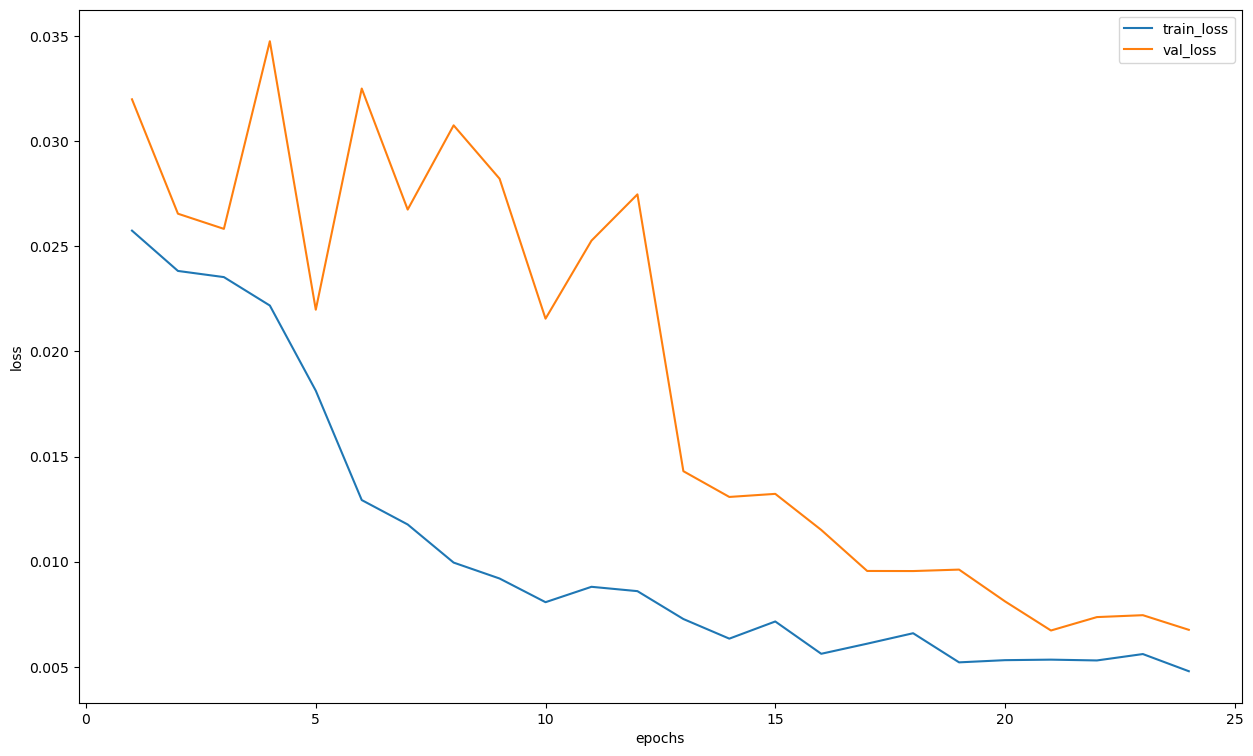

In [937]:
plt.figure(figsize=(15, 9))
plt.plot(range(1, len(loss) + 1), loss, label="train_loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [71]:
X, Y = next(iter(test_dataloader))

In [969]:
with torch.no_grad():
    X_pred = segnet(X).numpy()

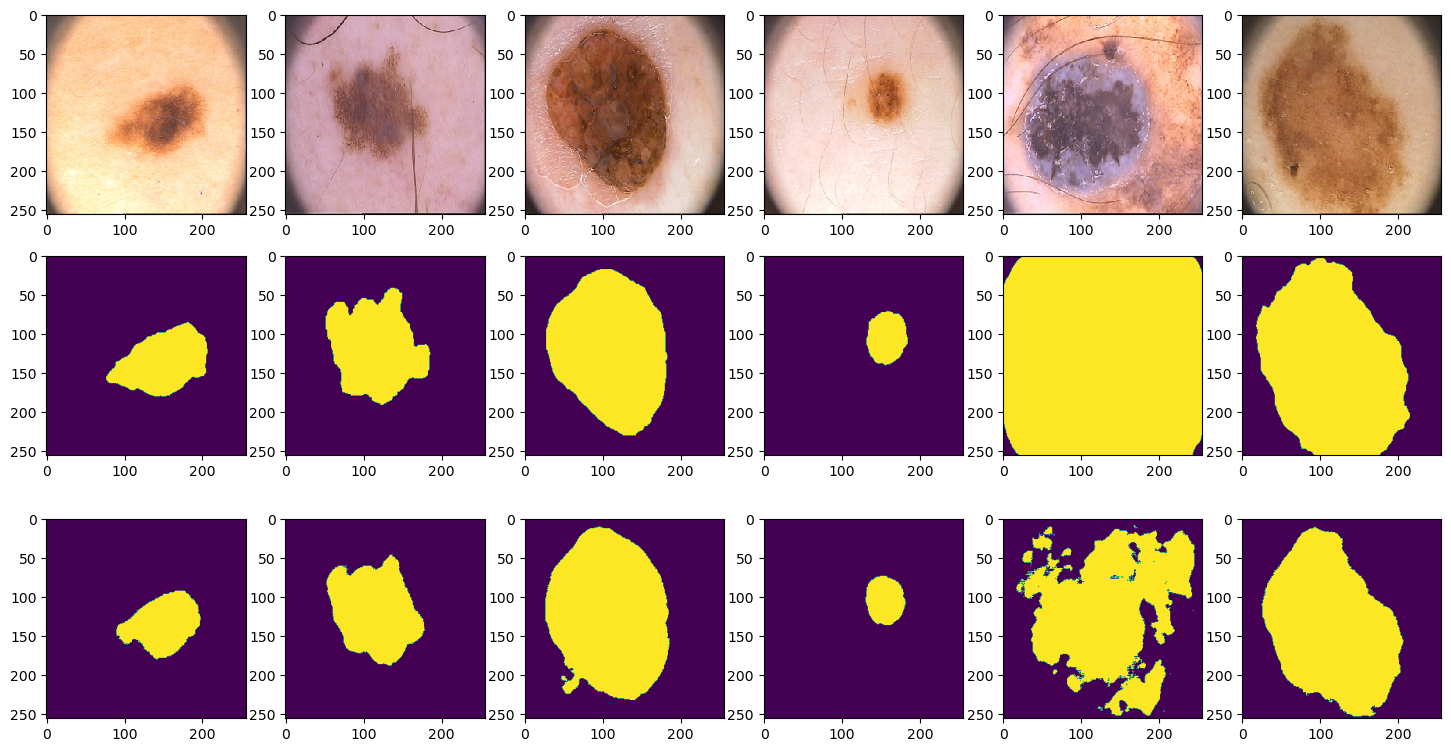

In [970]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 24))
for i in range(6):
    axes = plt.subplot(1, 6, i + 1)  # image
    plt.imshow(X[i].numpy().transpose(1, 2, 0), interpolation="nearest")

    plt.subplot(2, 6, i + 7)  # prediction
    plt.imshow(X_pred[i].transpose(1, 2, 0) > 0.5)

    plt.subplot(4, 6, i + 13)  # ground truth
    plt.imshow(Y[i].squeeze())

plt.show();

In [971]:
dice(
    torch.Tensor(X_pred).sigmoid(),
    torch.Tensor(Y).int(),
)

tensor(0.8778)

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

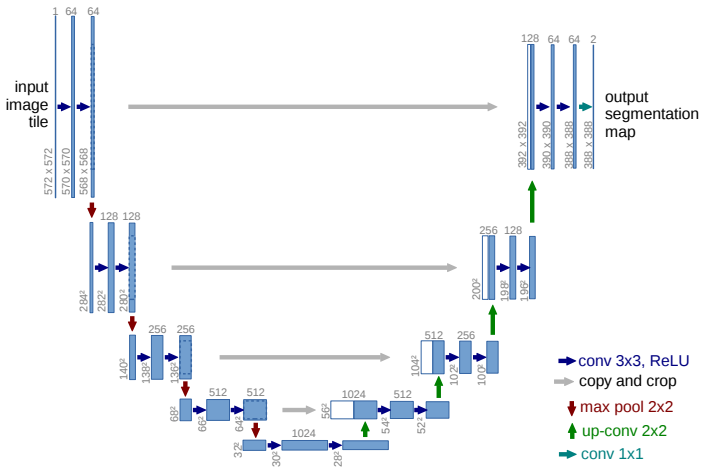

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [51]:
def make_conv_blocks(
    in_channels: int,
    out_channels: int,
) -> nn.Sequential:
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            bias=False,
        ),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            bias=False,
        ),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
    )

In [56]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_blocks = make_conv_blocks(in_channels, out_channels)
        self.max_pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv_blocks(x)
        residual = self.max_pool(x)
        return residual, x

In [57]:
class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2
        )
        self.conv_blocks = make_conv_blocks(in_channels, out_channels)

    def forward(self, x, residual):
        x = self.deconv(x)
        u = torch.cat([x, residual], dim=1)
        u = self.conv_blocks(u)
        return u

In [59]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.enc_block_1 = UNetEncoder(in_channels, 64)
        self.enc_block_2 = UNetEncoder(64, 128)
        self.enc_block_3 = UNetEncoder(128, 256)
        self.enc_block_4 = UNetEncoder(256, 512)

        self.bottleneck = make_conv_blocks(512, 1024)

        self.dec_block_1 = UNetDecoder(1024, 512)
        self.dec_block_2 = UNetDecoder(512, 256)
        self.dec_block_3 = UNetDecoder(256, 128)
        self.dec_block_4 = UNetDecoder(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x, residual_1 = self.enc_block_1(x)
        x, residual_2 = self.enc_block_2(x)
        x, residual_3 = self.enc_block_3(x)
        x, residual_4 = self.enc_block_4(x)

        x = self.bottleneck(x)

        x = self.dec_block_1(x, residual_4)
        x = self.dec_block_2(x, residual_3)
        x = self.dec_block_3(x, residual_2)
        x = self.dec_block_4(x, residual_1)

        return self.out(x)

## Обучите UNet

### BCE loss

In [60]:
unet = UNet().to(DEVICE)

In [ ]:
unet_history = train(
    train_dataloader,
    valid_dataloader,
    model=unet,
    num_epochs=25,
    # lr=2e-4,
    # weight_decay=1e-3,
    # lr=lr,
    # criterion=criterion,
    # initial_epoch=epoch,
    # optimizer=optimizer,
    # loss=loss,
)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 55213.8925
New loss minimum found, model saved as best_unet.pt

    Epoch 1    train_loss: 36073.5344, val_loss: 55213.8925
    
loss 1291838.24

    Epoch 2    train_loss: 23782.5728, val_loss: 1291838.2400
    
loss 771745.36

    Epoch 3    train_loss: 19768.5675, val_loss: 771745.3600
    
loss 582300.64

    Epoch 4    train_loss: 18327.0547, val_loss: 582300.6400
    
loss 58267.44

    Epoch 5    train_loss: 16601.3013, val_loss: 58267.4400
    
loss 54800.5375
New loss minimum found, model saved as best_unet.pt

    Epoch 6    train_loss: 16886.9434, val_loss: 54800.5375
    
loss 43178.6525
New loss minimum found, model saved as best_unet.pt

    Epoch 7    train_loss: 14123.4366, val_loss: 43178.6525
    
loss 43400.7925

    Epoch 8    train_loss: 14458.3016, val_loss: 43400.7925
    
loss 30110.5525
New loss minimum found, model saved as best_unet.pt

    Epoch 9    train_loss: 13491.0623, val_loss: 30110.5525
    
loss 26612.69125
New loss minimum found, model saved a

In [1107]:
loss, val_loss = zip(*unet_history[4:])

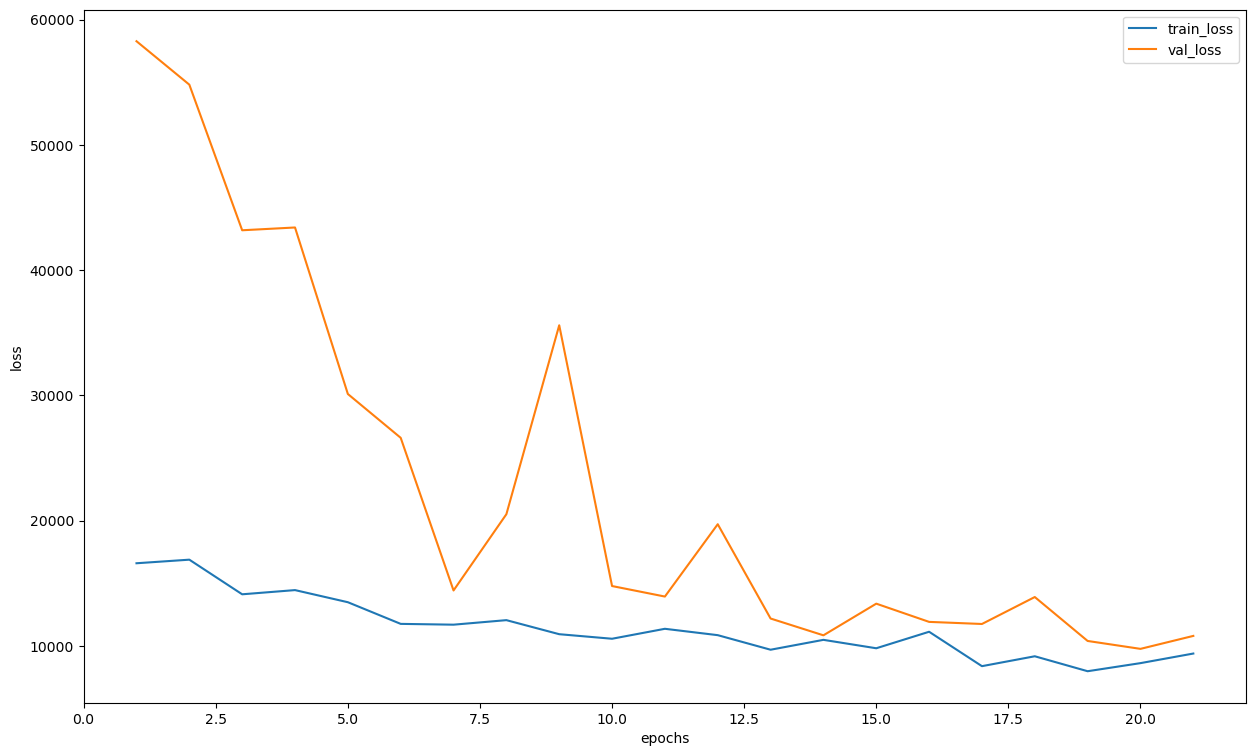

In [1108]:
plt.figure(figsize=(15, 9))
plt.plot(range(1, len(loss) + 1), loss, label="train_loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [61]:
best_unet = UNet().to(DEVICE)
unet_checkpoint = torch.load(f"best_{UNet.__name__.lower()}.pt", weights_only=False)
best_unet.load_state_dict(unet_checkpoint["model_state_dict"])

<All keys matched successfully>

In [72]:
with torch.no_grad():
    X_pred_unet = best_unet(X)

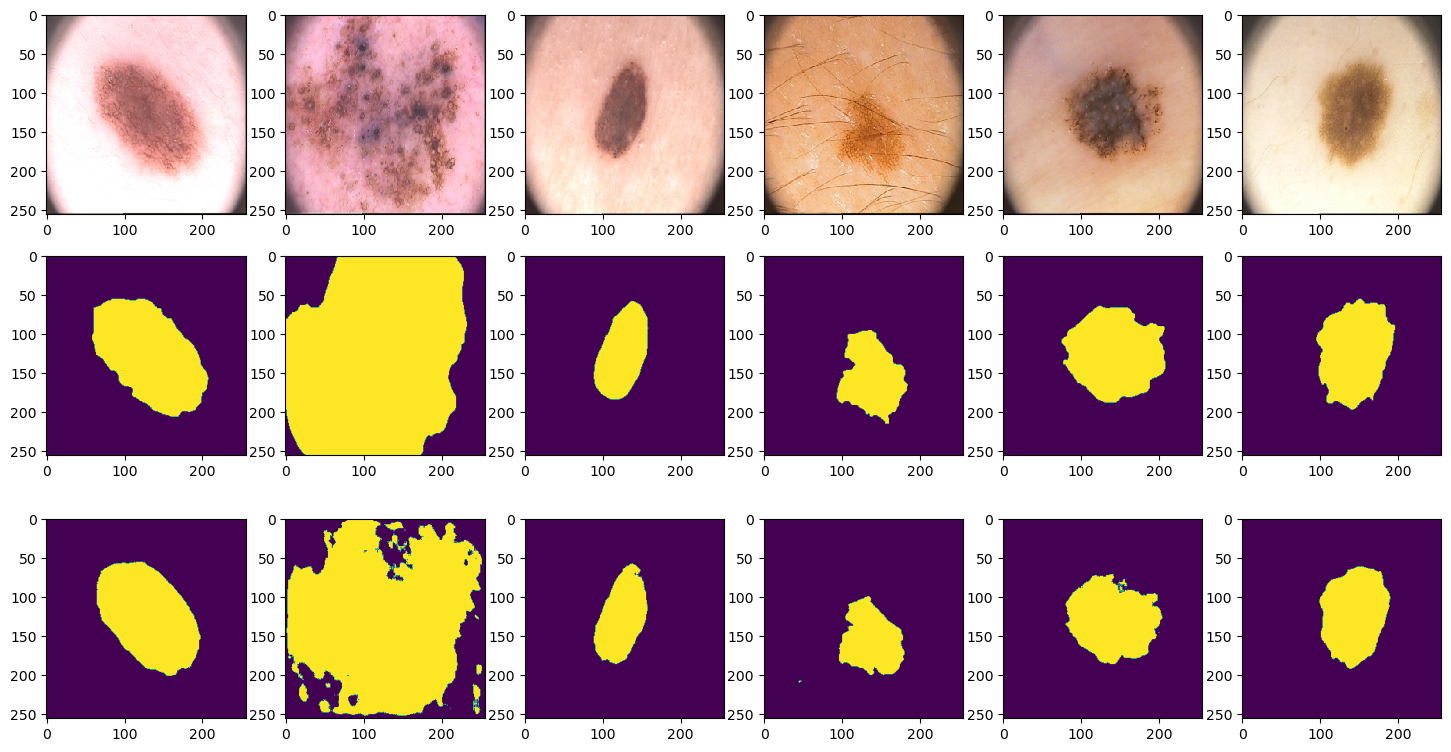

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 24))
for i in range(6):
    axes = plt.subplot(1, 6, i + 1)  # image
    plt.imshow(X[i].numpy().transpose(1, 2, 0), interpolation="nearest")

    plt.subplot(2, 6, i + 7)  # prediction
    plt.imshow(X_pred_unet[i].numpy().transpose(1, 2, 0) > 0.5)

    plt.subplot(4, 6, i + 13)  # ground truth
    plt.imshow(Y[i].squeeze())

plt.show();

In [74]:
dice(
    torch.Tensor(X_pred_unet).sigmoid(),
    torch.Tensor(Y).int(),
)

tensor(0.9192)

In [80]:
iou_score(X_pred_unet, Y)

tensor(0.8506)

### Dice loss

In [990]:
unet_dice = UNet().to(DEVICE)

In [991]:
unet_dice_history = train(
    train_dataloader,
    valid_dataloader,
    model=unet_dice,
    num_epochs=25,
    criterion=dice_loss_torch,
)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 0.022890418767929077
New loss minimum found, model saved as best_unet.pt

    Epoch 1    train_loss: 0.0176, val_loss: 0.0229
    
loss 0.0240057110786438

    Epoch 2    train_loss: 0.0109, val_loss: 0.0240
    
loss 0.013065516948699951
New loss minimum found, model saved as best_unet.pt

    Epoch 3    train_loss: 0.0102, val_loss: 0.0131
    
loss 0.01699933648109436

    Epoch 4    train_loss: 0.0091, val_loss: 0.0170
    
loss 0.01391675353050232

    Epoch 5    train_loss: 0.0082, val_loss: 0.0139
    
loss 0.024610327482223512

    Epoch 6    train_loss: 0.0079, val_loss: 0.0246
    
loss 0.01257899522781372
New loss minimum found, model saved as best_unet.pt

    Epoch 7    train_loss: 0.0066, val_loss: 0.0126
    
loss 0.011442204713821411
New loss minimum found, model saved as best_unet.pt

    Epoch 8    train_loss: 0.0065, val_loss: 0.0114
    
loss 0.01169562578201294

    Epoch 9    train_loss: 0.0061, val_loss: 0.0117
    
loss 0.009444601535797119
New loss minimum

In [ ]:
loss, val_loss = zip(*unet_dice_history)

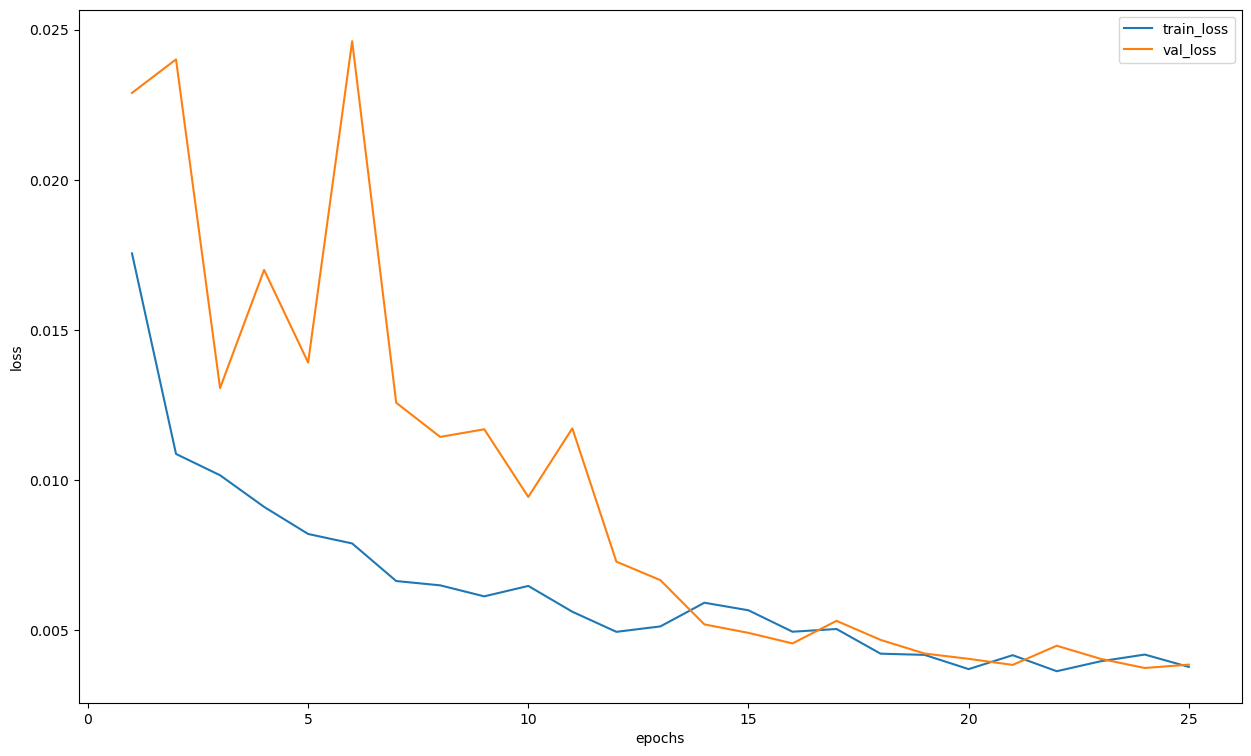

In [995]:
plt.figure(figsize=(15, 9))
plt.plot(range(1, len(loss) + 1), loss, label="train_loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [1003]:
best_unet = UNet().to(DEVICE)
unet_checkpoint = torch.load(f"best_{UNet.__name__.lower()}.pt", weights_only=False)
best_unet.load_state_dict(unet_checkpoint["model_state_dict"])

<All keys matched successfully>

In [1004]:
with torch.no_grad():
    X_pred_unet_dice = unet(X).numpy()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 24))
for i in range(6):
    axes = plt.subplot(1, 6, i + 1)  # image
    plt.imshow(X[i].numpy().transpose(1, 2, 0), interpolation="nearest")

    plt.subplot(2, 6, i + 7)  # prediction
    plt.imshow(X_pred_unet_dice[i].transpose(1, 2, 0) > 0.5)

    plt.subplot(4, 6, i + 13)  # ground truth
    plt.imshow(Y[i].squeeze())

plt.show();

# К сожалению, картинка весит слишком много для Степика, пришлось удалить :(

In [1006]:
dice(
    torch.Tensor(X_pred_unet_dice).sigmoid(),
    torch.Tensor(Y).int(),
)

tensor(0.8659)

### Focal loss

In [1110]:
from functools import partial

focal_loss = partial(sigmoid_focal_loss, alpha=-1, gamma=2, reduction="sum")

In [ ]:
unet_focal = UNet().to(DEVICE)

In [ ]:
unet_focal_history = train(
    train_dataloader,
    valid_dataloader,
    model=unet_focal,
    num_epochs=25,
    criterion=focal_loss,
)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 10867.630625
New loss minimum found, model saved as best_unet.pt

    Epoch 1    train_loss: 11195.4850, val_loss: 10867.6306
    
loss 600308.24

    Epoch 2    train_loss: 6330.4535, val_loss: 600308.2400
    
loss 182047.68

    Epoch 3    train_loss: 5124.4302, val_loss: 182047.6800
    
loss 25849.120625

    Epoch 4    train_loss: 4447.1303, val_loss: 25849.1206
    
loss 7178.62625
New loss minimum found, model saved as best_unet.pt

    Epoch 5    train_loss: 4702.5053, val_loss: 7178.6263
    
loss 11567.061875

    Epoch 6    train_loss: 4381.6476, val_loss: 11567.0619
    
loss 8161.0478125

    Epoch 7    train_loss: 4334.0174, val_loss: 8161.0478
    
loss 8165.9740625

    Epoch 8    train_loss: 3977.9649, val_loss: 8165.9741
    
loss 4950.230625
New loss minimum found, model saved as best_unet.pt

    Epoch 9    train_loss: 3718.9334, val_loss: 4950.2306
    
loss 5446.939375

    Epoch 10    train_loss: 3440.5691, val_loss: 5446.9394
    
loss 4762.69453125
New lo

In [ ]:
loss, val_loss = zip(*unet_focal_history[5:])

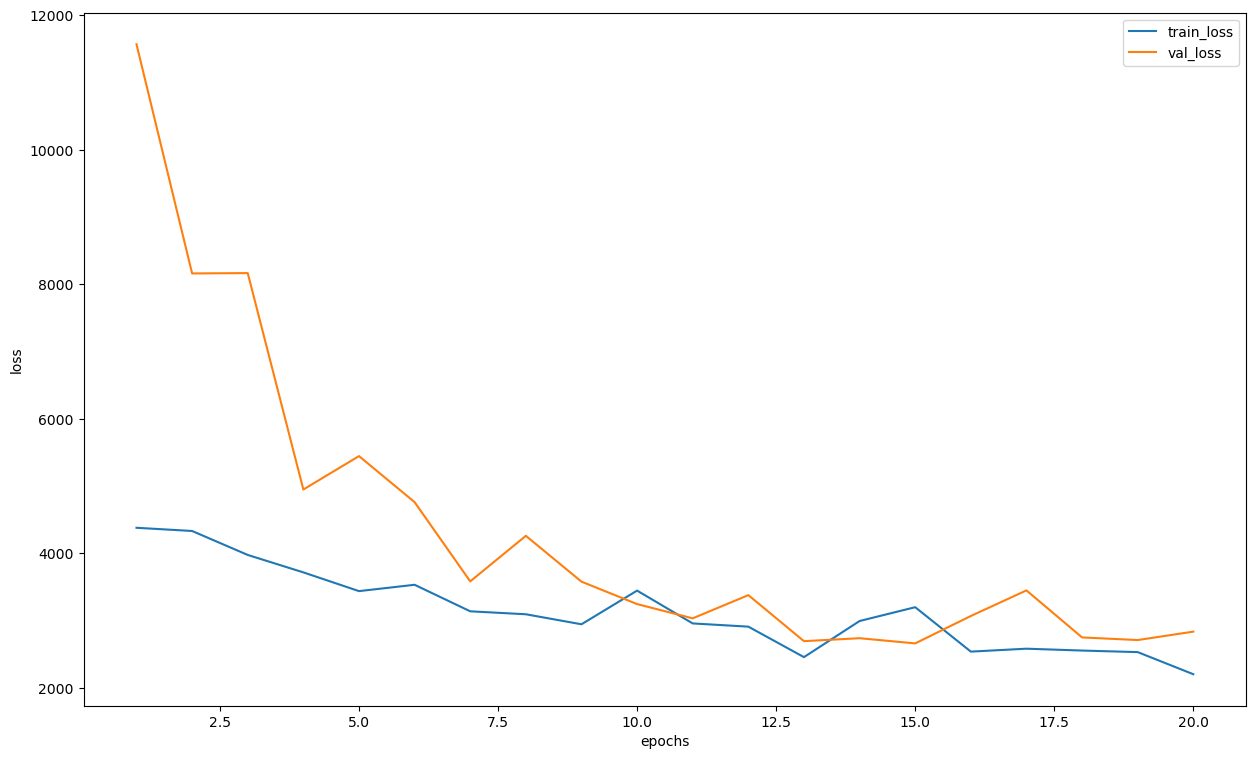

In [1120]:
plt.figure(figsize=(15, 9))
plt.plot(range(1, len(loss) + 1), loss, label="train_loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [1121]:
best_focal_unet = UNet().to(DEVICE)
unet_focal_checkpoint = torch.load(
    f"best_{UNet.__name__.lower()}.pt",
    weights_only=False,
)
best_focal_unet.load_state_dict(unet_checkpoint["model_state_dict"])

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    X_pred_unet_focal = best_focal_unet(X)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 24))
for i in range(6):
    axes = plt.subplot(1, 6, i + 1)  # image
    plt.imshow(X[i].numpy().transpose(1, 2, 0), interpolation="nearest")

    plt.subplot(2, 6, i + 7)  # prediction
    plt.imshow(X_pred_unet_focal[i].numpy().transpose(1, 2, 0) > 0.5)

    plt.subplot(4, 6, i + 13)  # ground truth
    plt.imshow(Y[i].squeeze())

plt.show();

# К сожалению, картинка весит слишком много для Степика, пришлось удалить :(

In [1124]:
dice(
    X_pred_unet_focal.sigmoid(),
    Y.int(),
)

tensor(0.7967)

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
    - Лучший результат после 25-ти эпох даёт SegNet c Focal loss со значением DICE-метрики 0.8778
*   Какая модель дает лучшие значения по лоссам?
    - SegNet c Focal loss, значение функции потерь на лучшем прогоне на валидации – 0.0067
*   Какая модель обучается быстрее?
    - SegNet с DiceLoss учится 37м 12с (25 эпох)
*   Сравните визуально результаты SegNet и UNet.
    - Сделано выше

Напишите развернутый ответ на вопросы.